In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('../data/agg_all.csv')
raw_df.head()

,Time,Max Concentration,Last Pit,Track Temp,Wind Speed,Yellow
0,20.0,30.833709,0.333333,61.055717,2.518879,0
1,40.0,19.788881,0.666667,61.055717,2.518879,0
2,60.0,22.615864,1.000000,61.055717,2.518879,0
3,80.0,24.406780,1.333333,61.055717,2.518879,0
4,100.0,17.844887,1.666667,61.055717,2.518879,0


In [5]:
raw_df.describe()

,Time,Max Concentration,Last Pit,Track Temp,Wind Speed,Yellow
count,16891.000000,16891.000000,16891.000000,16891.000000,16891.000000,16891.000000
mean,42361.776094,7.364814,62.006760,61.172940,2.518879,0.011367
std,24539.387772,3.256360,42.687264,8.434643,4.346888,0.106012
min,20.000000,0.533049,0.333333,32.000000,0.000000,0.000000
25%,21140.000000,5.088569,45.080842,57.000020,0.600000,0.000000
50%,42280.000000,6.784759,52.045633,61.055717,2.518879,0.000000
75%,63410.000000,8.564919,61.064183,64.000040,2.600000,0.000000
max,86540.000000,33.333333,340.886167,98.000060,168.100000,1.000000


In [6]:
neg, pos = np.bincount(raw_df['Yellow'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 16891
    Positive: 192 (1.14% of total)



In [7]:
cleaned_df = raw_df.copy()
cleaned_df.pop('Time')
# cleaned_df.pop('Max Concentration')

eps = 0.001 
# cleaned_df['Time'] = np.log(cleaned_df['Time']+eps)
cleaned_df['Last Pit'] = np.log(cleaned_df['Last Pit']+eps)

In [8]:
cleaned_df.describe()

,Max Concentration,Last Pit,Track Temp,Wind Speed,Yellow
count,16891.000000,16891.000000,16891.000000,16891.000000,16891.000000
mean,7.364814,3.994513,61.172940,2.518879,0.011367
std,3.256360,0.495075,8.434643,4.346888,0.106012
min,0.533049,-1.095617,32.000000,0.000000,0.000000
25%,5.088569,3.808480,57.000020,0.600000,0.000000
50%,6.784759,3.952140,61.055717,2.518879,0.000000
75%,8.564919,4.111942,64.000040,2.600000,0.000000
max,33.333333,5.831552,98.000060,168.100000,1.000000


In [9]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Yellow'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Yellow'))
test_labels = np.array(test_df.pop('Yellow'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (10809,)
Validation labels shape: (2703,)
Test labels shape: (3379,)
Training features shape: (10809, 4)
Validation features shape: (2703, 4)
Test features shape: (3379, 4)


C:\Users\dithu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\dithu\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


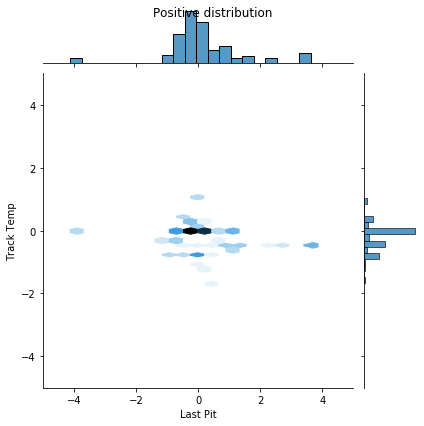

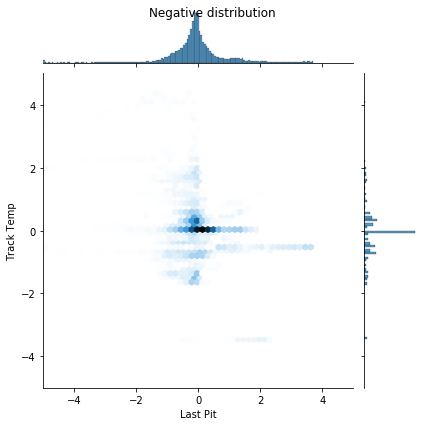

In [11]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['Last Pit'], pos_df['Track Temp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['Last Pit'], neg_df['Track Temp'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [12]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None, dropout=0.5):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(dropout),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
    ])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [14]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                80        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


In [15]:
model.predict(train_features[:10])

array([[0.4198808 ],
       [0.7013759 ],
       [0.44887263],
       [0.725103  ],
       [0.47029907],
       [0.6291754 ],
       [0.60772014],
       [0.67596555],
       [0.59413314],
       [0.5256884 ]], dtype=float32)

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.0137


In [17]:
initial_bias = np.log([pos/neg])
initial_bias

array([-4.46560874])

In [18]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.01004398],
       [0.0094339 ],
       [0.01545808],
       [0.01977196],
       [0.01808527],
       [0.01359931],
       [0.01283041],
       [0.01070499],
       [0.01133302],
       [0.01252621]], dtype=float32)

In [19]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0629


In [20]:
initial_weights = '../data/inital_weights'
model.save_weights(initial_weights)

In [21]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [22]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [23]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

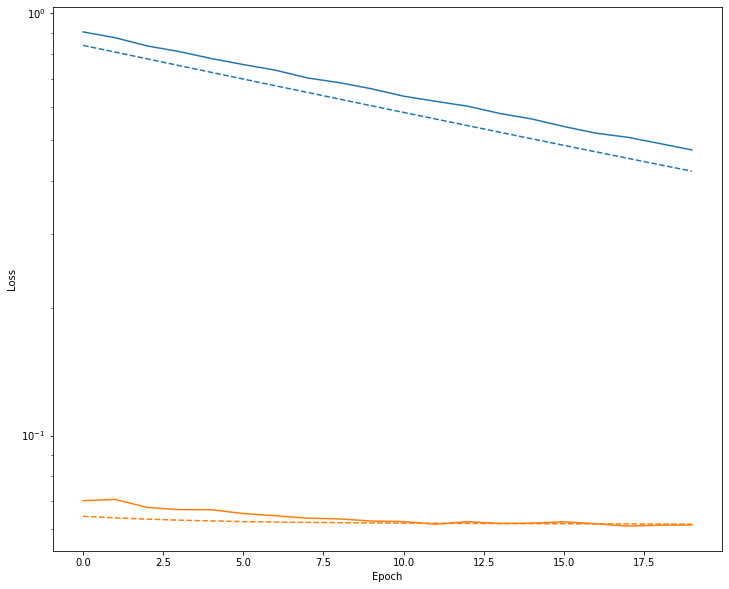

In [24]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

BASELINE

In [25]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00013: early stopping


In [26]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.4,.8])
        else:
            plt.ylim([-0.1,1])

        plt.legend()

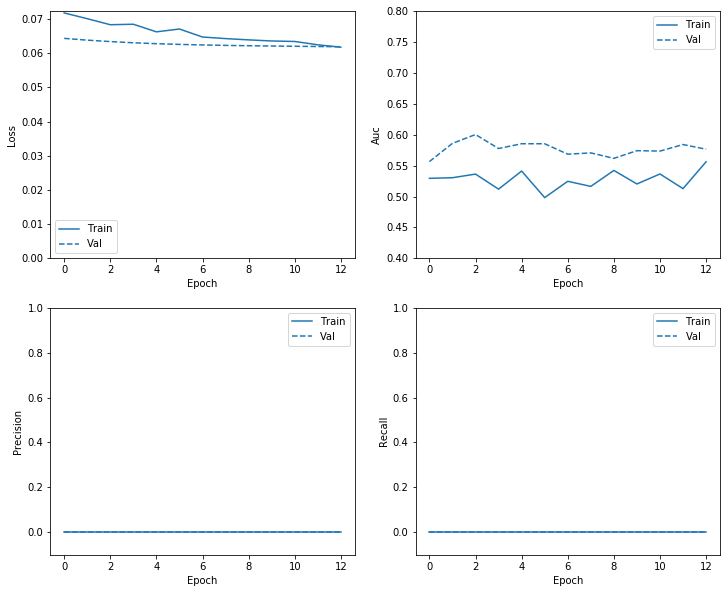

In [27]:
plot_metrics(baseline_history)

In [28]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [29]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Green Flags Predicted (True Negatives): ', cm[0][0])
    print('Yellow Flags Incorrectly Predicted (False Positives): ', cm[0][1])
    print('Yellow Flags Missed (False Negatives): ', cm[1][0])
    print('Yellow Flags Correctly Predicted (True Positives): ', cm[1][1])
    print('Total Yellow Flags: ', np.sum(cm[1]))

loss :  0.07083755731582642
tp :  0.0
fp :  0.0
tn :  3335.0
fn :  44.0
accuracy :  0.9869784116744995
precision :  0.0
recall :  0.0
auc :  0.5379514694213867

Green Flags Predicted (True Negatives):  3335
Yellow Flags Incorrectly Predicted (False Positives):  0
Yellow Flags Missed (False Negatives):  44
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  44


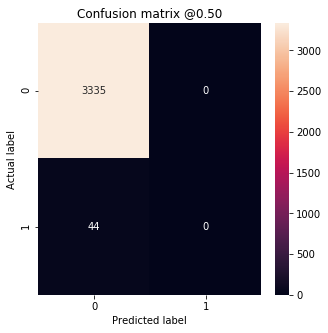

In [30]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [31]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim([-0.5,100])
    plt.ylim([0,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

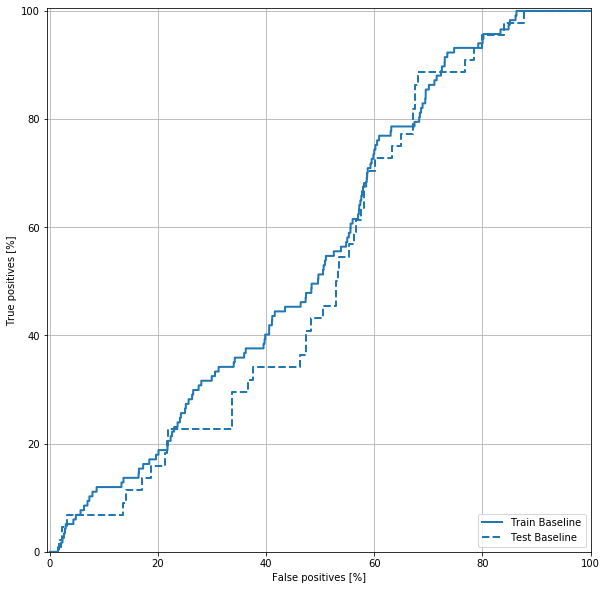

In [32]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [33]:
temp = list(zip(train_labels, train_predictions_baseline))
temp = [t[1] for t in temp if t[0] == 1]
print(stats.describe(temp))
print(stats.describe(train_predictions_baseline))
print('========================')
temp = list(zip(test_labels, test_predictions_baseline))
temp = [t[1] for t in temp if t[0] == 1]
print(stats.describe(temp))
print(stats.describe(test_predictions_baseline))

DescribeResult(nobs=117, minmax=(array([0.00946492], dtype=float32), array([0.05119768], dtype=float32)), mean=array([0.01497488], dtype=float32), variance=array([4.9595776e-05], dtype=float32), skewness=array([2.9029913], dtype=float32), kurtosis=array([8.829468], dtype=float32))
DescribeResult(nobs=10809, minmax=(array([0.0016126], dtype=float32), array([0.31140655], dtype=float32)), mean=array([0.01484417], dtype=float32), variance=array([0.00015187], dtype=float32), skewness=array([11.52681], dtype=float32), kurtosis=array([227.36682], dtype=float32))
DescribeResult(nobs=44, minmax=(array([0.00922132], dtype=float32), array([0.04893816], dtype=float32)), mean=array([0.01473679], dtype=float32), variance=array([6.364362e-05], dtype=float32), skewness=array([3.2038326], dtype=float32), kurtosis=array([9.540898], dtype=float32))
DescribeResult(nobs=3379, minmax=(array([0.00299796], dtype=float32), array([0.3111087], dtype=float32)), mean=array([0.01490699], dtype=float32), variance=ar

WEIGHTED

In [34]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 87.97


In [35]:
weighted_model = make_model(dropout=.5)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight,
    verbose=0
)

Restoring model weights from the end of the best epoch.
Epoch 00017: early stopping


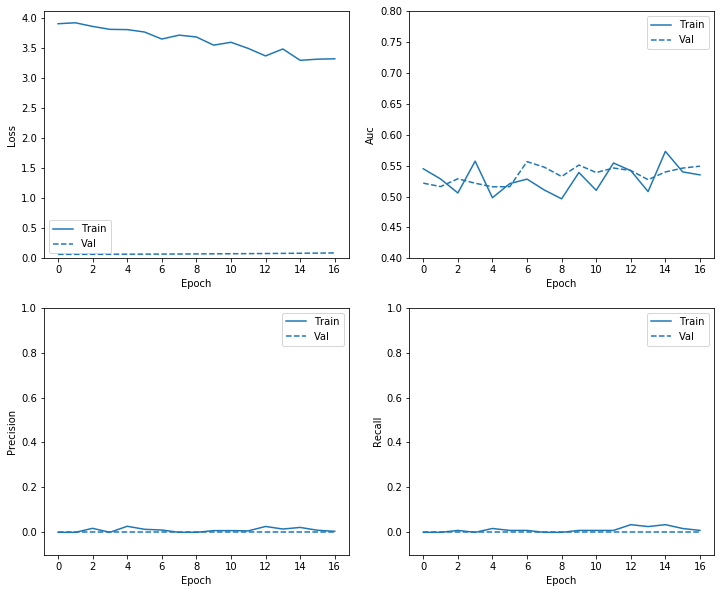

In [36]:
plot_metrics(weighted_history)

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.07762983441352844
tp :  0.0
fp :  1.0
tn :  3334.0
fn :  44.0
accuracy :  0.9866824746131897
precision :  0.0
recall :  0.0
auc :  0.5118269920349121

Green Flags Predicted (True Negatives):  3334
Yellow Flags Incorrectly Predicted (False Positives):  1
Yellow Flags Missed (False Negatives):  44
Yellow Flags Correctly Predicted (True Positives):  0
Total Yellow Flags:  44


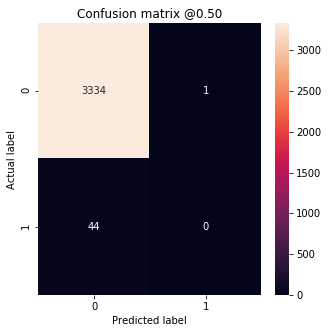

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [39]:
temp = list(zip(train_labels, train_predictions_weighted))
temp = [t[1] for t in temp if t[0] == 1]
print(stats.describe(temp))
print(stats.describe(train_predictions_weighted))
print('========================')
temp = list(zip(test_labels, test_predictions_weighted))
temp = [t[1] for t in temp if t[0] == 1]
print(stats.describe(temp))
print(stats.describe(test_predictions_weighted))

DescribeResult(nobs=117, minmax=(array([0.01366535], dtype=float32), array([0.17164025], dtype=float32)), mean=array([0.02600202], dtype=float32), variance=array([0.00059107], dtype=float32), skewness=array([3.7515788], dtype=float32), kurtosis=array([15.370306], dtype=float32))
DescribeResult(nobs=10809, minmax=(array([0.00253564], dtype=float32), array([0.7908085], dtype=float32)), mean=array([0.0258438], dtype=float32), variance=array([0.00134574], dtype=float32), skewness=array([9.5088005], dtype=float32), kurtosis=array([142.15808], dtype=float32))
DescribeResult(nobs=44, minmax=(array([0.01335192], dtype=float32), array([0.1628783], dtype=float32)), mean=array([0.02590889], dtype=float32), variance=array([0.00085188], dtype=float32), skewness=array([3.6114748], dtype=float32), kurtosis=array([12.203143], dtype=float32))
DescribeResult(nobs=3379, minmax=(array([0.00756621], dtype=float32), array([0.7903057], dtype=float32)), mean=array([0.02615352], dtype=float32), variance=array(

In [40]:
THRESHOLD = np.quantile(test_predictions_weighted, .95)
s = list(filter(lambda t: t > THRESHOLD ,test_predictions_weighted))
s = set(list(np.array(s).transpose()[0]))
print(len(s))
# s.intersection
temp = set(list(np.array(temp).transpose()[0]))
s.intersection(temp)

169


{0.10520157, 0.11796382, 0.1628783}

RESAMPLED

In [41]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [42]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [43]:
for features, label in pos_ds.take(1):
    print("Features:\n", features.numpy())
    print()
    print("Label: ", label.numpy())

Features:
 [-0.60272501  3.63361373 -0.49388422  1.42329143]

Label:  1


In [44]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.37, 0.63])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [45]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.3779296875


In [46]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

17.0

In [47]:
resampled_model = make_model(dropout=0.02)
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds,
    verbose=0
)

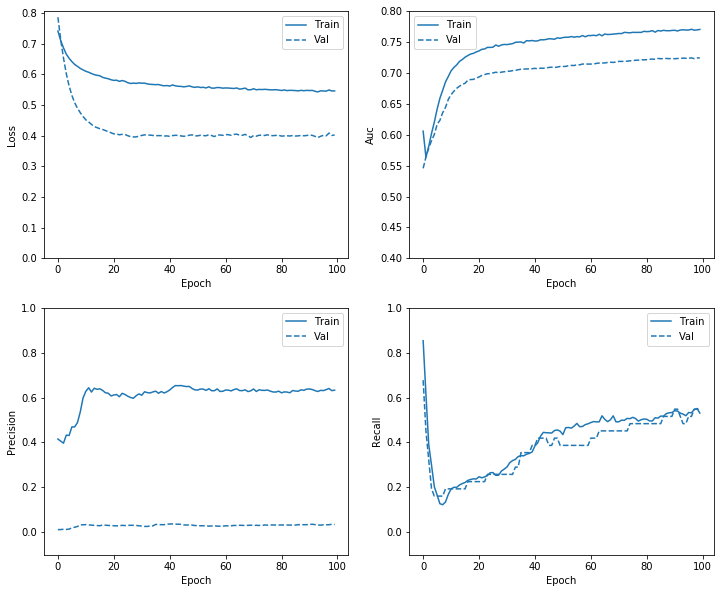

In [48]:
plot_metrics(resampled_history)

In [49]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.39853793382644653
tp :  16.0
fp :  574.0
tn :  2761.0
fn :  28.0
accuracy :  0.821840763092041
precision :  0.02711864374577999
recall :  0.3636363744735718
auc :  0.7528178691864014

Green Flags Predicted (True Negatives):  2761
Yellow Flags Incorrectly Predicted (False Positives):  574
Yellow Flags Missed (False Negatives):  28
Yellow Flags Correctly Predicted (True Positives):  16
Total Yellow Flags:  44


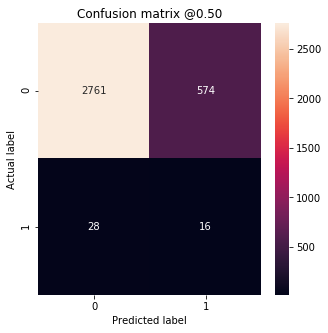

In [50]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

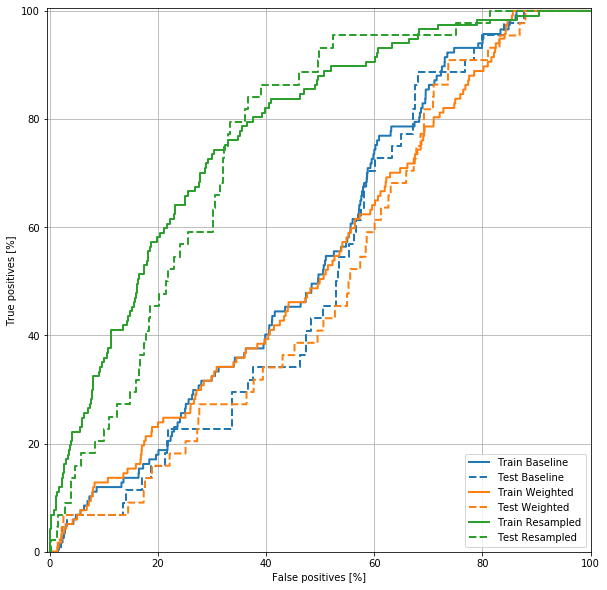

In [51]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')

In [52]:
temp = list(zip(train_labels, train_predictions_resampled))
temp = [t[1] for t in temp if t[0] == 1]
print(stats.describe(temp))
print(stats.describe(train_predictions_resampled))
print('========================')
temp = list(zip(test_labels, test_predictions_resampled))
temp = [t[1] for t in temp if t[0] == 1]
print(stats.describe(temp))
print(stats.describe(test_predictions_resampled))

DescribeResult(nobs=117, minmax=(array([0.05168939], dtype=float32), array([0.83360803], dtype=float32)), mean=array([0.49517456], dtype=float32), variance=array([0.02838292], dtype=float32), skewness=array([-0.5505527], dtype=float32), kurtosis=array([-0.14184737], dtype=float32))
DescribeResult(nobs=10809, minmax=(array([6.080488e-06], dtype=float32), array([0.83360803], dtype=float32)), mean=array([0.2991044], dtype=float32), variance=array([0.03780143], dtype=float32), skewness=array([0.29382733], dtype=float32), kurtosis=array([-1.0306653], dtype=float32))
DescribeResult(nobs=44, minmax=(array([0.09303227], dtype=float32), array([0.76310015], dtype=float32)), mean=array([0.46759608], dtype=float32), variance=array([0.02032227], dtype=float32), skewness=array([-0.43015885], dtype=float32), kurtosis=array([0.3654189], dtype=float32))
DescribeResult(nobs=3379, minmax=(array([2.905055e-05], dtype=float32), array([0.84104025], dtype=float32)), mean=array([0.29601598], dtype=float32), v

In [53]:
THRESHOLD = np.quantile(test_predictions_resampled, .99)
s = list(filter(lambda t: t > THRESHOLD ,test_predictions_resampled))
s = set(list(np.array(s).transpose()[0]))
# s.intersection
temp = set(list(np.array(temp).transpose()[0]))
s.intersection(temp)

{0.76310015}